In [243]:
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage
import datashader as ds
import numpy as np
import pandas as pd
import numexpr as ne
import datashader.transfer_functions as tf
from datashader.colors import Greys9, Hot, viridis, inferno, colormap_select as cm 
from datashader import reductions
from datashader.core import bypixel
from utils import toWebMercator, mega_color

In [9]:
file = r'D:\ADSB\working\h5\2017-01-16.h5'
store = pd.HDFStore(file)
points = store.select('data',columns=['Lat','Long','Cou']).dropna()
points = points.query('Lat>=-90').query('Lat<=90').query('Long>=-180').query('Long<=180')
points = points.drop_duplicates()

,Lat,Long,Cou
6,23.450592,113.342050,China
10,0.000001,0.000000,France
13,-45.629898,0.000000,Unknown or unassigned country
18,29.147690,106.679146,China
24,32.542408,-116.973580,Mexico


In [117]:
import yaml
with open('mega_color.yaml') as f:
    mc = yaml.load(f)
mega_color = mc['mega_color']
mega_color = [v.replace('"',"").replace(' ','').strip() for v in mega_color.replace("'","").split(',')]

In [88]:
x_we, y_we = toWebMercator(points['Long'],points['Lat'])
we = pd.DataFrame(np.vstack([x_we,y_we])).T
we.columns = ['x','y']
we['country'] = list(points.Cou)

In [89]:
we['country'] = we['country'].astype('category')
we['country'] = we['country'].replace([np.inf,-np.inf],np.nan).dropna()

Quick way to get to locations

In [253]:
MaxBounds = ((20048966.10, -20048966.10), (20026376.39, -20026376.39))
DataSetBounds = ((min(we.x),max(we.x)), (min(we.y),max(we.y)))
USA = ((-13884029, -7453304), (2698291, 6455972))
Germany = ((5000000, 6200000), (500000, 2000000))
# Chicago = (( -9828281, -9717659), (5096658, 5161298))
# Chinatown = (( -9759210, -9754583), (5137122, 5139825))
# NewYorkCity = (( -8280656, -8175066), (4940514, 4998954))
# LosAngeles = ((-13195052, -13114944), (3979242, 4023720))
# Houston = ((-10692703, -10539441), (3432521, 3517616))
# Austin = ((-10898752, -10855820), (3525750, 3550837))
# NewOrleans = ((-10059963, -10006348), (3480787, 3510555))
Atlanta = (( -9448349, -9354773), (3955797, 4007753))
xrange, yrange = USA

In [258]:
plot_width, plot_height = 900, 500
glyph = ds.glyphs.Point('x', 'y')
canvas = ds.Canvas(plot_width, plot_height, *DataSetBounds)
reduction = reductions.count()
agg = bypixel(we, canvas, glyph, reduction)

canvas.points(we, 'x', 'y', agg=reductions.count())

<xarray.DataArray (y_axis: 500, x_axis: 900)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * y_axis   (y_axis) float64 -1.025e+07 -1.021e+07 -1.016e+07 -1.012e+07 ...
  * x_axis   (x_axis) float64 -1.986e+07 -1.982e+07 -1.977e+07 -1.973e+07 ...

In [259]:
def bg(img): 
    return tf.set_background(img,"black")

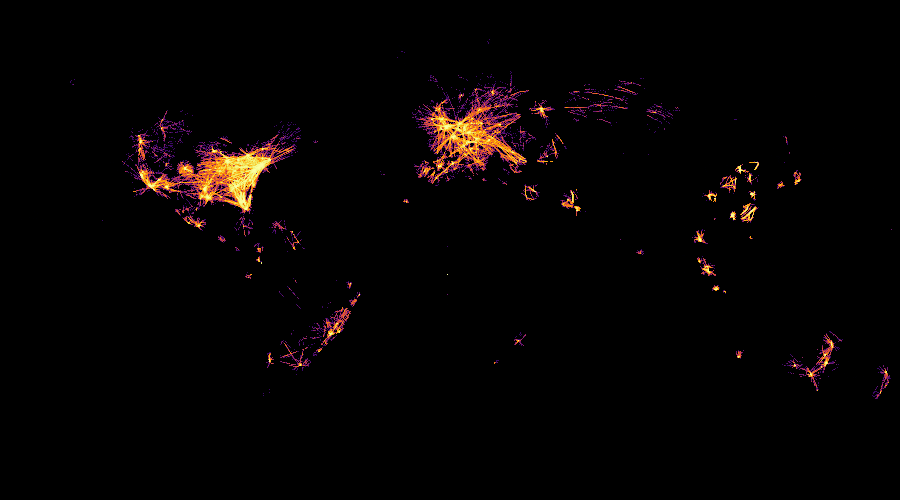

In [260]:
tf.set_background(tf.shade(canvas.points(we, 'x', 'y', agg=reductions.count()), 
                           cmap=inferno),"black")

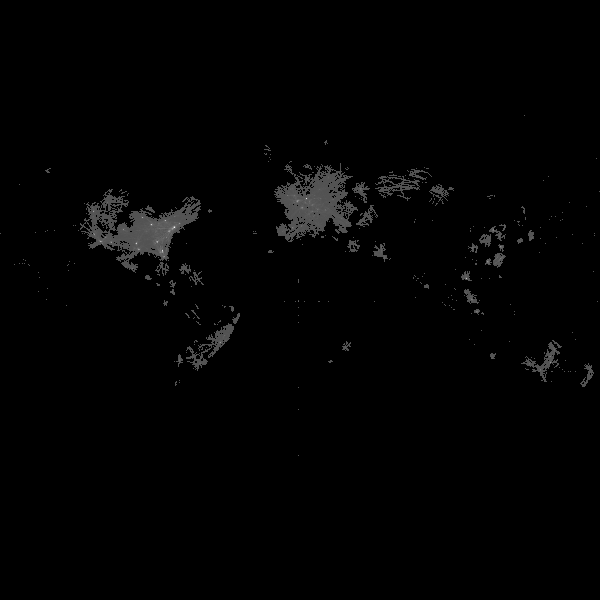

In [238]:
agg  = canvas.points(we, 'x', 'y')
bg(tf.shade(agg, cmap = cm(Greys9,0.25), how='linear'))

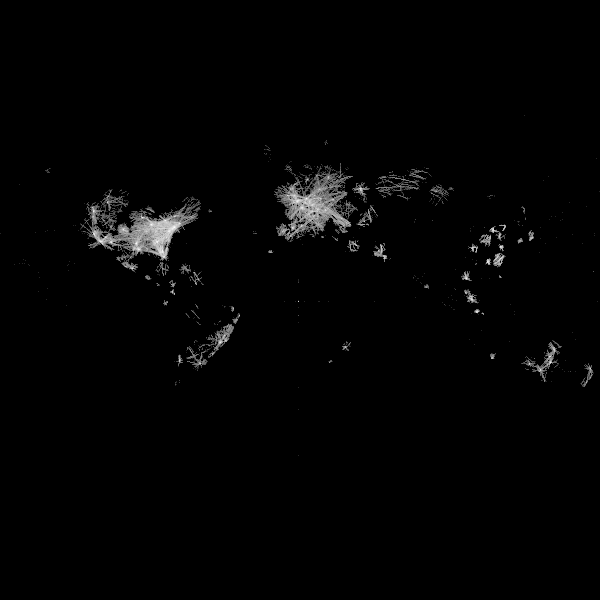

In [157]:
bg(tf.shade(agg, cmap = cm(Greys9,0.2), how='log'))

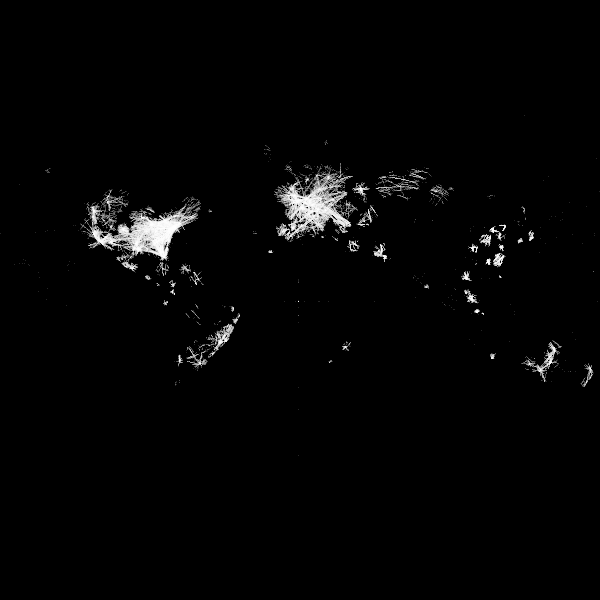

In [158]:
bg(tf.shade(agg, cmap = cm(Greys9,0.2), how='eq_hist'))

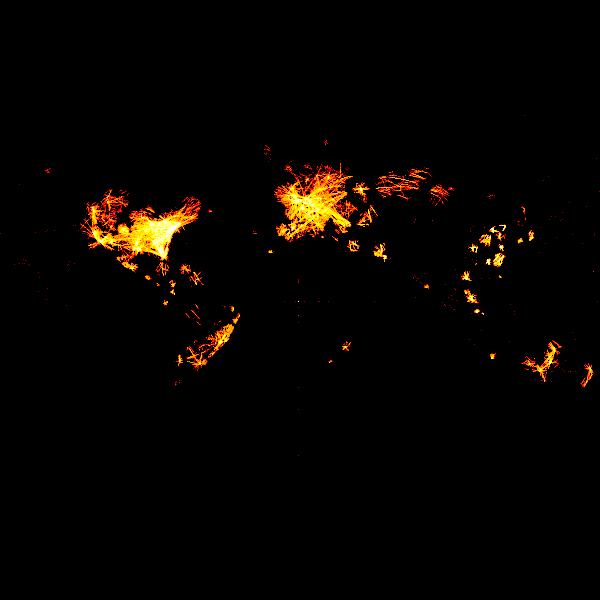

In [159]:
bg(tf.shade(agg, cmap = cm(Hot,0.2)))

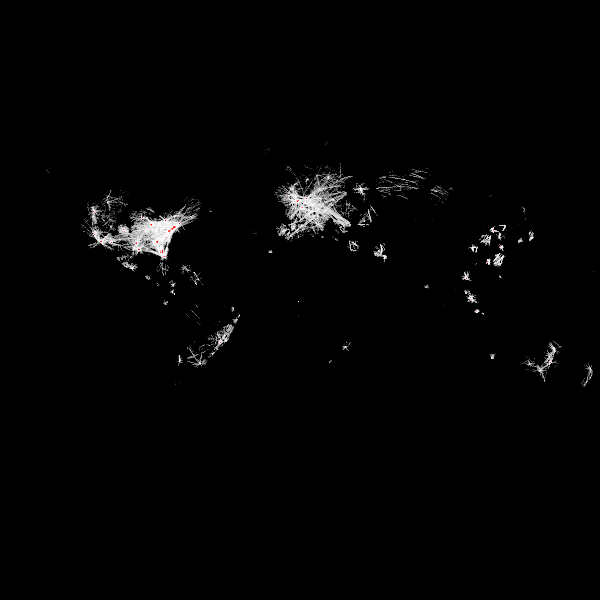

In [160]:
grays2 = cm([(i,i,i) for i in np.linspace(0,255,99)]) + ["red"]
bg(tf.shade(agg, cmap = grays2))

In [224]:
def create_image(x_range, y_range, w, h, spread=0):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    pnts = cvs.points(we, 'x', 'y', ds.count_cat('country'))
    img = tf.shade(pnts, color_key=mega_color,how='eq_hist')

    if spread: img = tf.spread(img,px=spread)
    return tf.set_background(img,"black")

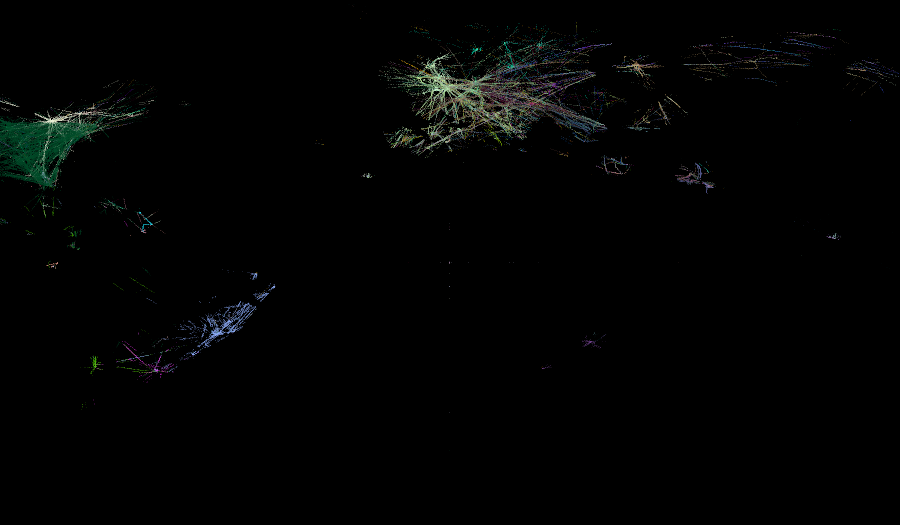

In [226]:
plot_width = int(900)
plot_height = int(plot_width*7.0/12)
create_image((-10000000,10000000),(-10000000,10000000),plot_width,plot_height)

In [220]:
from bokeh.models.tiles import WMTSTileSource
def base_plot(tools='pan,wheel_zoom,box_zoom,reset',webgl=False,
              xrange=xrange,yrange=yrange,plot_width=int(900),plot_height=int(500)):
    p = bp.figure(tools=tools,
                  plot_width=plot_width, plot_height=plot_height,
                  x_range=xrange, y_range=yrange, outline_line_color=None,
                  min_border=0, min_border_left=0, min_border_right=0,
                  min_border_top=0, min_border_bottom=0, webgl=webgl)
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
 
    return p
 
p = base_plot(xrange=tuple(np.dot([-1,1],5*10**6)),yrange=tuple(np.dot([-1,1],5*10**6)))
 
# url="http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.png" 
cartocdn = "http://a.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png"
tile_renderer = p.add_tile(WMTSTileSource(url=cartocdn)) 
tile_renderer.alpha=0.9

In [221]:
from datashader.bokeh_ext import InteractiveImage
np.seterr(divide='ignore', invalid='ignore')
def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    pnts = cvs.points(we, 'x', 'y', ds.count_cat('country'))
#     img = tf.colorize(agg, color_mapper, 'log')
    img = tf.shade(pnts, color_key=mega_color,how='log')
    return tf.dynspread(img,threshold=0.75, max_px=8)
 
InteractiveImage(p, image_callback)

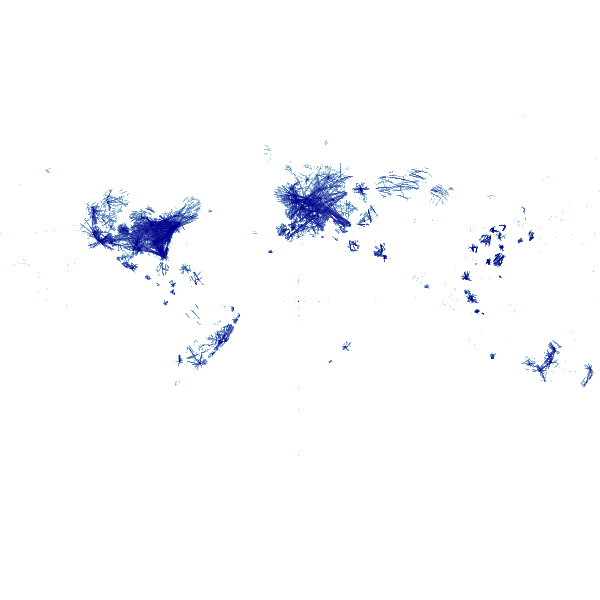

In [181]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

country_list = list(we['country'].astype(str).unique())
def my_select_handler(selection):
    tf.shade(canvas.points(we[we['country']==selection], 'x', 'y'))
interact(my_select_handler,selection=country_list)
tf.shade(canvas.points(we, 'x', 'y')) 

In [150]:
agg  = canvas.points(we, 'x', 'y')
tf.shade(agg.where(agg>=np.percentile(agg,2)))

TypeError: Expected `Image`, got: `<class 'xarray.core.dataarray.DataArray'>`

In [94]:
aggc = canvas.points(we, 'x', 'y', ds.count_cat('country'))

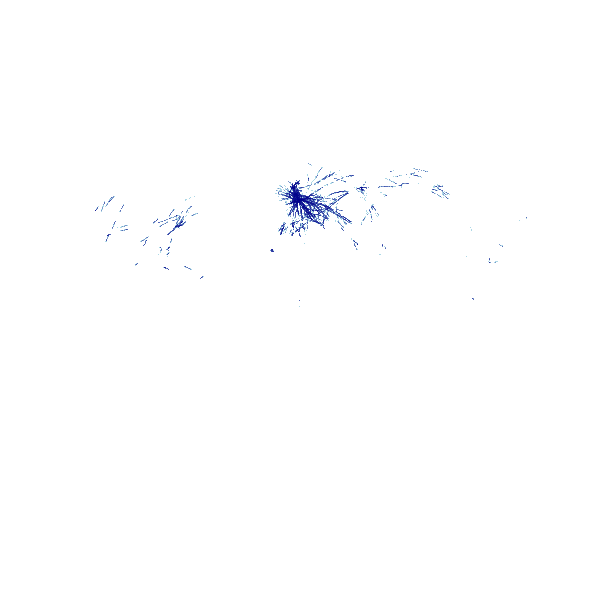

In [91]:
tf.shade(aggc.sel(country='United Kingdom'))

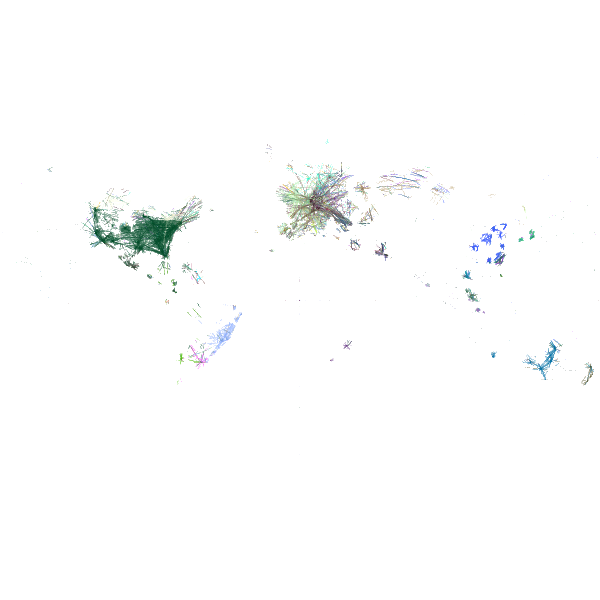

In [56]:



keys = list(we.groupby('country').count().index)
np.random.shuffle(keys)
color_mapper = dict.fromkeys(keys)
for i, k in enumerate(keys):
    color_mapper[k] = mega_color[i]
we['color'] = we['country'].map(color_mapper)

In [ ]:
openmap='http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png'
carto_retina_dark_all="http://cartobase-a.global.ssl.fastly.net/{dark_all}/{z}/{x}/{y}@2x.png"
carto_retina_dark_nolabels="http://cartobase-{s}.global.ssl.fastly.net/{dark_nolabels}/{z}/{x}/{y}@2x.png"
carto_retina_dark_only_labels="http://cartobase-{s}.global.ssl.fastly.net/{dark_only_labels}/{z}/{x}/{y}@2x.png"
carto_dark_all="http://cartobase-a.global.ssl.fastly.net/{dark_all}/{z}/{x}/{y}.png"
carto_dark_nolabels="http://cartobase-{s}.global.ssl.fastly.net/{dark_nolabels}/{z}/{x}/{y}.png"
carto_dark_only_labels="http://cartobase-{s}.global.ssl.fastly.net/{dark_only_labels}/{z}/{x}/{y}.png"